In [4]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


In [5]:
from scipy.stats import skew

skewness_ds = (
    ds.groupby("category")["amt"]
    .apply(lambda x: skew(x, bias=False))
    .reset_index(name="skewness")
    .sort_values("skewness", ascending=False)
)

print(skewness_ds)

          category  skewness
13          travel   20.7990
12    shopping_pos    8.8350
11    shopping_net    8.1642
9         misc_pos    5.3916
8         misc_net    4.1726
0    entertainment    2.7337
10   personal_care    2.0818
1      food_dining    2.0477
5   health_fitness    1.8546
7        kids_pets    1.8077
6             home    1.7355
4      grocery_pos    1.1245
3      grocery_net    0.6986
2    gas_transport    0.2464


Da mind. eine Gruppe (hier eine Kategorie) starke Schiefe zeigt (z.b. die Kategorie "Travel"), ist ANOVA ungeeignet und sogar unzuverlässig, weshalb wir Kruskal-Wallis verwenden.

In [6]:
from scipy.stats import kruskal

groups = [g["amt"].values for _, g in ds.groupby("category")]

stat, p = kruskal(*groups)

print("Kruskal-Wallis Test")
print("Statistic:", stat)
print("p-value :", p)

Kruskal-Wallis Test
Statistic: 262024.5463747941
p-value : 0.0


Da der p-value extrem klein ist, können wir die Nullhypothese verwerfen (H_0: Alle Kategorien haben die gleiche Verteilung des Transaktionsbetrags). Es gibt also Kategorien, deren Transaktionsbeträge systematisch unterschiedlich sind.

In [7]:
import scikit_posthocs as sp
raw_dunn = sp.posthoc_dunn(
    ds,
    val_col='amt',
    group_col='category',
    p_adjust=None
)
raw_dunn

,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
entertainment,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
food_dining,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
gas_transport,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_net,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_pos,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
health_fitness,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
home,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
kids_pets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


Da wir sehr viele unkorrigierte p-values haben (sehr viele p-values fast gleich Null), benutzen wir nun FDR-Korrektur

In [8]:
from statsmodels.stats.multitest import multipletests

# Extract the upper-triangle p-values
pvals = raw_dunn.values[np.triu_indices_from(raw_dunn, k=1)]

# Apply FDR correction
reject, pvals_corrected, _, _ = multipletests(
    pvals,
    alpha=0.05,
    method="fdr_bh"
)

# Reconstruct corrected p-value matrix
categories = raw_dunn.columns
corr_matrix = pd.DataFrame(
    np.zeros_like(raw_dunn, dtype=float),
    index=categories,
    columns=categories
)

idx = 0
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        corr_matrix.iloc[i, j] = pvals_corrected[idx]
        corr_matrix.iloc[j, i] = pvals_corrected[idx]
        idx += 1

corr_matrix

,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
entertainment,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
food_dining,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
gas_transport,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
grocery_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
health_fitness,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
home,0.2618,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
kids_pets,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_net,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
misc_pos,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Bis auf die Kategorien Entertainment vs Home unterscheiden sich alle Kategorien signifikant von einander

Die Analyse zeigt deutlich, dass sich die Transaktionsbeträge zwischen nahezu allen Kategorien signifikant unterscheiden. Aufgrund der starken Schiefe der Verteilungen war eine nichtparametrische Vorgehensweise erforderlich. Der Kruskal-Wallis-Test ergab einen hochsignifikanten Gesamteffekt, was auf systematische Unterschiede zwischen den Gruppen hinweist. Die anschließenden Dunn-Post-hoc-Tests mit FDR-Korrektur bestätigten, dass fast alle Kategorien paarweise unterschiedliche Ausgabenniveaus aufweisen. Lediglich die Kategorien Entertainment und Home zeigten keinen signifikanten Unterschied. Insgesamt verdeutlichen die Ergebnisse, dass die Art der Transaktion einen klaren Einfluss auf die Höhe der getätigten Beträge hat, was inhaltlich gut mit den typischen Ausgabemustern dieser Kategorien übereinstimmt.

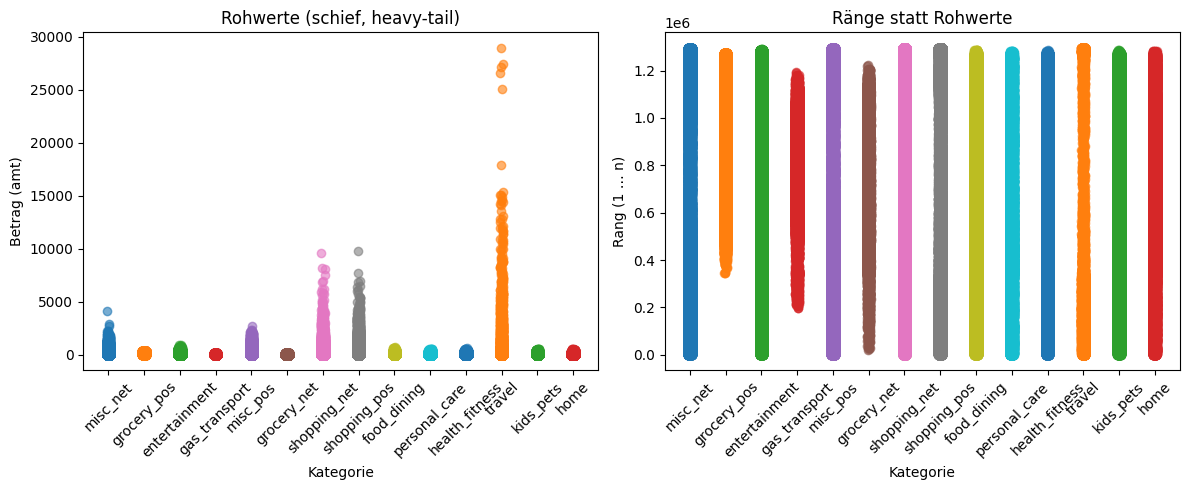

In [13]:
# Evtl. nur 3–4 Kategorien anzeigen:
cats = ds['category'].unique()
ds_plot = ds.copy()

# Ränge (global über alle Beobachtungen – wie bei Kruskal)
ds_plot['rank'] = ds_plot['amt'].rank(method='average')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Links: Rohwerte (schief, heavy-tail)
axes[0].set_title("Rohwerte (schief, heavy-tail)")
for i, cat in enumerate(cats):
    y = ds_plot.loc[ds_plot['category'] == cat, 'amt']
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[0].scatter(x, y, alpha=0.6, label=cat)
axes[0].set_xticks(range(len(cats)))
axes[0].set_xticklabels(cats, rotation=45)
axes[0].set_xlabel("Kategorie")
axes[0].set_ylabel("Betrag (amt)")

# Rechts: Ränge statt Rohwerte
axes[1].set_title("Ränge statt Rohwerte")
for i, cat in enumerate(cats):
    y = ds_plot.loc[ds_plot['category'] == cat, 'rank']
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[1].scatter(x, y, alpha=0.6, label=cat)
axes[1].set_xticks(range(len(cats)))
axes[1].set_xticklabels(cats, rotation=45)
axes[1].set_xlabel("Kategorie")
axes[1].set_ylabel("Rang (1 … n)")

plt.tight_layout()
plt.show()

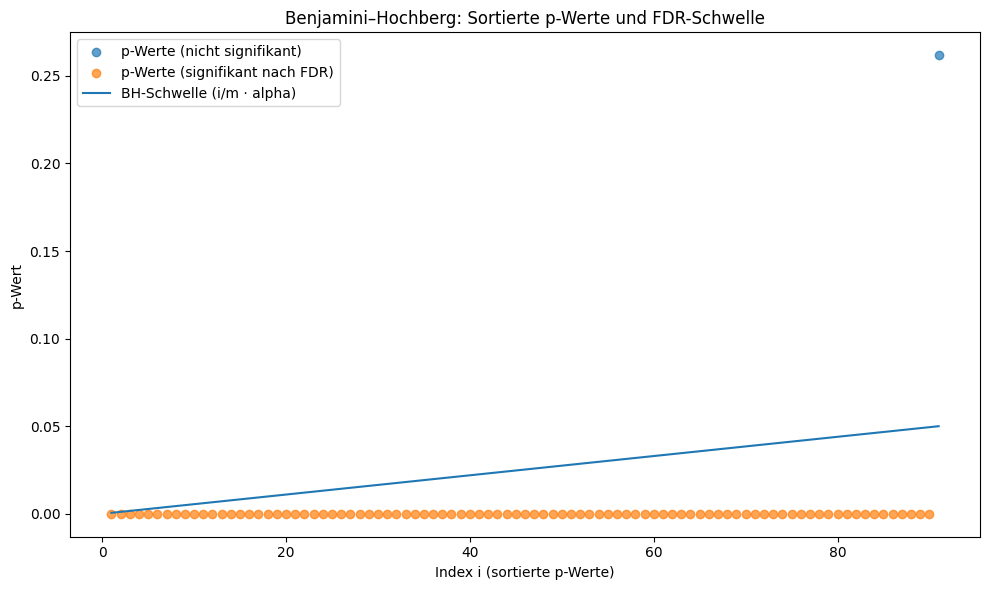

In [10]:
# p-Werte aus oberem Dreieck der Matrix
pvals = raw_dunn.values[np.triu_indices_from(raw_dunn, k=1)]

# Sortieren
p_sorted = np.sort(pvals)
m = len(p_sorted)
alpha = 0.05
bh_thresholds = (np.arange(1, m+1) / m) * alpha

# Welche sind signifikant nach BH?
significant = p_sorted <= bh_thresholds

plt.figure(figsize=(10, 6))
x = np.arange(1, m+1)

# nicht signifikant
plt.scatter(x[~significant], p_sorted[~significant], label="p-Werte (nicht signifikant)", alpha=0.7)
# signifikant
plt.scatter(x[significant], p_sorted[significant], label="p-Werte (signifikant nach FDR)", alpha=0.7)

# BH-Schwelle
plt.plot(x, bh_thresholds, label="BH-Schwelle (i/m · alpha)")

plt.xlabel("Index i (sortierte p-Werte)")
plt.ylabel("p-Wert")
plt.title("Benjamini–Hochberg: Sortierte p-Werte und FDR-Schwelle")
plt.legend()
plt.tight_layout()
plt.show()

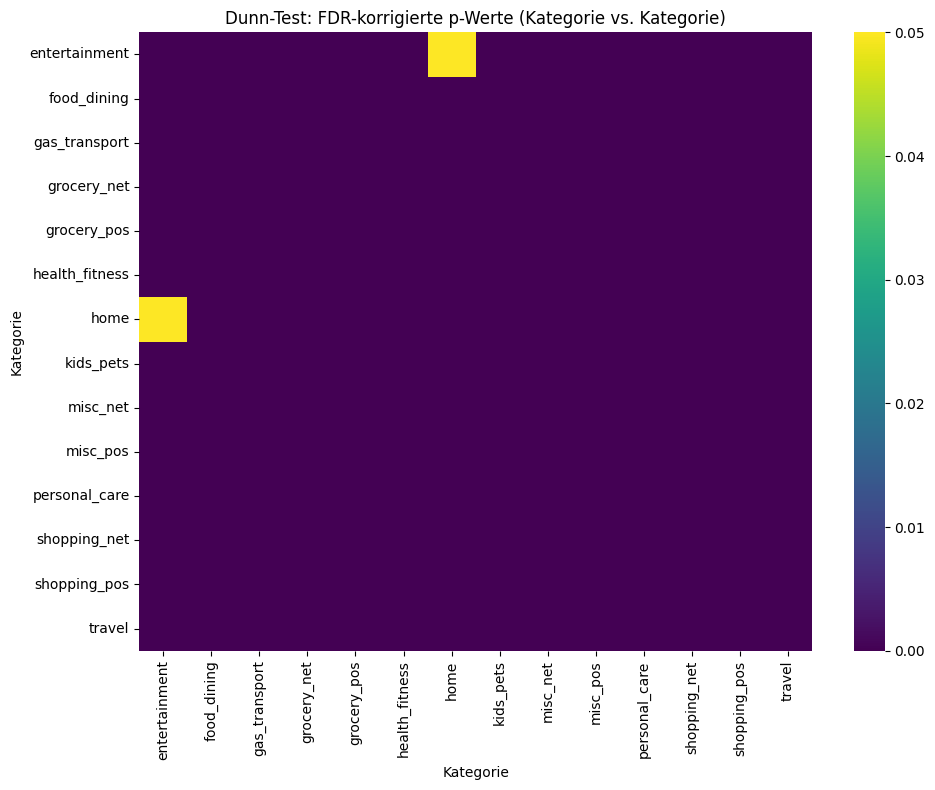

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="viridis", vmin=0, vmax=0.05)
plt.title("Dunn-Test: FDR-korrigierte p-Werte (Kategorie vs. Kategorie)")
plt.xlabel("Kategorie")
plt.ylabel("Kategorie")
plt.tight_layout()
plt.show()

In [35]:

# Cohen's d Funktion
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    mx = np.mean(x)
    my = np.mean(y)
    vx = np.var(x, ddof=1)
    vy = np.var(y, ddof=1)
    pooled_sd = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    return (mx - my) / pooled_sd

# Mittelwerte je Kategorie
cat_means = ds.groupby("category")["amt"].mean()

# Alle Paarvergleiche sammeln
rows = []

groups = corr_matrix.index.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1 = groups[i]
        g2 = groups[j]

        p = corr_matrix.loc[g1, g2]

        x = ds[ds["category"] == g1]["amt"]
        y = ds[ds["category"] == g2]["amt"]

        m1 = cat_means[g1]
        m2 = cat_means[g2]
        diff = m2 - m1

        d = cohens_d(x, y)

        d_class = (
            "negligible" if abs(d) < 0.2 else
            "small"       if abs(d) < 0.5 else
            "medium"      if abs(d) < 0.8 else
            "large"
        )

        rows.append({
            "Kategorie 1": g1,
            "Kategorie 2": g2,
            "MW Kat 1": m1,
            "MW Kat 2": m2,
            "Diff (K2 - K1)": diff,
            "p-Wert (FDR)": p,
            "Cohen's d": d,
            "Effekt-Kategorie": d_class
        })


cat_compare_df = pd.DataFrame(rows)
cat_compare_df["p-Wert (FDR)"] = cat_compare_df["p-Wert (FDR)"].apply(lambda x: format(x, ".12e"))

# Sortiert nach Effektstärke (|d|)
cat_compare_df = cat_compare_df.reindex(cat_compare_df["Cohen's d"].abs().sort_values().index)

pd.set_option("display.max_rows", None)
cat_compare_df

,Kategorie 1,Kategorie 2,MW Kat 1,MW Kat 2,Diff (K2 - K1),p-Wert (FDR),Cohen's d,Effekt-Kategorie
79,misc_net,shopping_pos,80.8651,79.7792,-1.0859,8.525920906818e-307,0.0051,negligible
31,gas_transport,misc_pos,63.4346,62.8910,-0.5436,0.000000000000e+00,0.0065,negligible
37,grocery_net,health_fitness,53.6701,54.1821,0.5121,5.394107309681e-145,-0.0123,negligible
8,entertainment,misc_pos,64.2104,62.8910,-1.3194,0.000000000000e+00,0.0127,negligible
63,home,kids_pets,58.2701,57.5369,-0.7333,1.074498067138e-11,0.0151,negligible
1,entertainment,gas_transport,64.2104,63.4346,-0.7758,0.000000000000e+00,0.0175,negligible
54,grocery_pos,travel,116.9610,111.5047,-5.4563,0.000000000000e+00,0.0177,negligible
78,misc_net,shopping_net,80.8651,88.4241,7.5590,5.340557797307e-124,-0.0345,negligible
88,shopping_net,shopping_pos,88.4241,79.7792,-8.6449,3.990887906131e-49,0.0362,negligible
65,home,misc_pos,58.2701,62.8910,4.6209,0.000000000000e+00,-0.0499,negligible


# Alter

In [14]:
ds["dob"] = pd.to_datetime(ds["dob"], errors="coerce")
age = (pd.Timestamp("2019-01-01") - ds["dob"]).dt.days / 365.25
ds["age"] = age

In [15]:
ds["age_group6"] = pd.qcut(
    ds["age"],
    q=6,
    labels=[
        "Sehr jung",
        "Jung",
        "Jung-Mittel",
        "Mittel",
        "Mittel-Alt",
        "Alt"
    ]
)

In [16]:
ds["age_group6"].value_counts()

age_group6
Sehr jung      217875
Mittel         217630
Mittel-Alt     215597
Jung-Mittel    215568
Alt            215073
Jung           214932
Name: count, dtype: int64

In [17]:
ds.groupby("age_group6")["amt"].skew()

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_17136/2335388974.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ds.groupby("age_group6")["amt"].skew()


age_group6
Sehr jung     31.5635
Jung          35.6496
Jung-Mittel   18.6543
Mittel        44.8872
Mittel-Alt    57.4771
Alt           50.5494
Name: amt, dtype: float64

In [19]:
from scipy.stats import kruskal

groups = [g["amt"].values for _, g in ds.groupby("age_group6")]

stat, p = kruskal(*groups)
print("Kruskal-Wallis:", stat, "p-value:", p)

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_17136/1395324746.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g["amt"].values for _, g in ds.groupby("age_group6")]


Kruskal-Wallis: 5058.391681821413 p-value: 0.0


In [20]:
import scikit_posthocs as sp

raw_dunn_age = sp.posthoc_dunn(
    ds,
    val_col="amt",
    group_col="age_group6",
    p_adjust=None
)

raw_dunn_age

,Sehr jung,Jung,Jung-Mittel,Mittel,Mittel-Alt,Alt
Sehr jung,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Jung-Mittel,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
Mittel,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Mittel-Alt,0.0000,0.0000,0.0000,0.0000,1.0000,0.4290
Alt,0.0000,0.0000,0.0000,0.0000,0.4290,1.0000


In [21]:
from statsmodels.stats.multitest import multipletests

pvals = raw_dunn_age.values[np.triu_indices_from(raw_dunn_age, k=1)]

reject, pvals_corrected, _, _ = multipletests(
    pvals, alpha=0.05, method="fdr_bh"
)

groups = raw_dunn_age.columns
corr_age = pd.DataFrame(
    np.zeros_like(raw_dunn_age, dtype=float),
    index=groups,
    columns=groups
)

idx = 0
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        corr_age.iloc[i, j] = pvals_corrected[idx]
        corr_age.iloc[j, i] = pvals_corrected[idx]
        idx += 1

corr_age

,Sehr jung,Jung,Jung-Mittel,Mittel,Mittel-Alt,Alt
Sehr jung,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jung-Mittel,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mittel,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mittel-Alt,0.0000,0.0000,0.0000,0.0000,0.0000,0.4290
Alt,0.0000,0.0000,0.0000,0.0000,0.4290,0.0000


/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_17136/2156100176.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df_plot.groupby("age_group6").sample(500, replace=False, random_state=42)


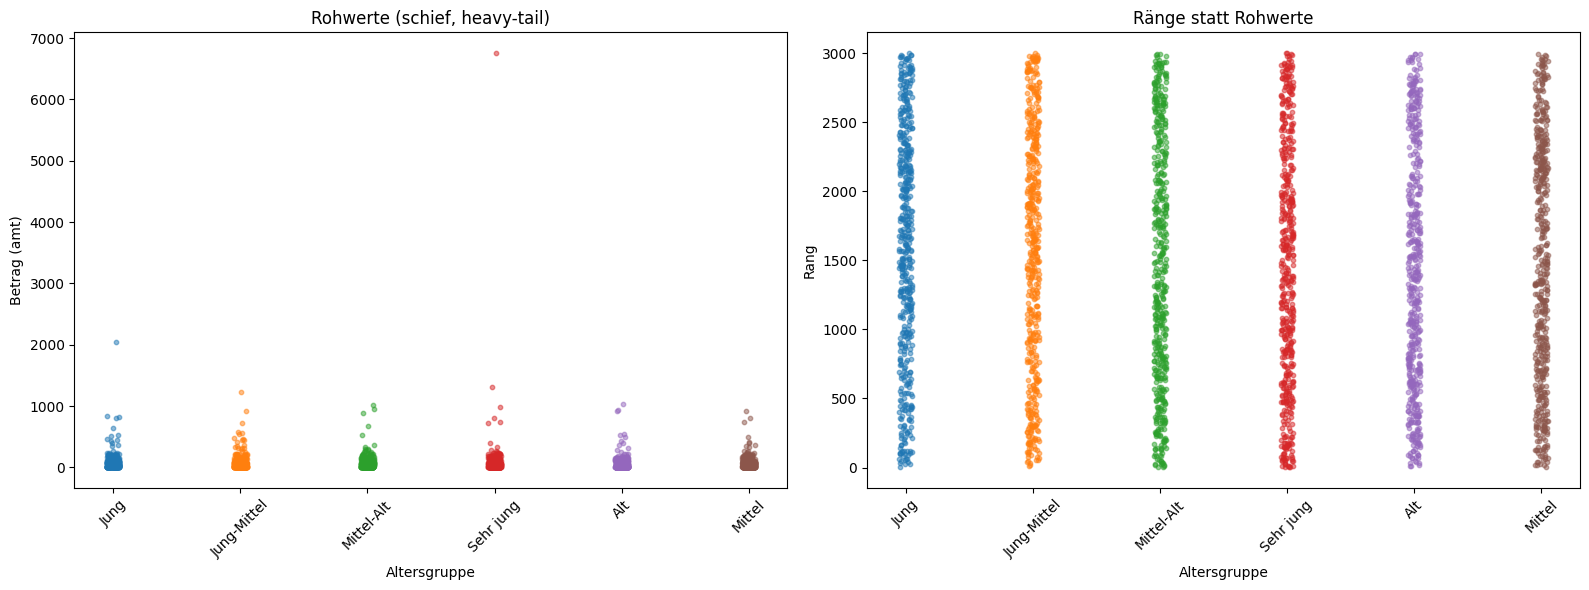

In [22]:
cats = ds["age_group6"].unique()
df_plot = ds.copy()

# Optional: Sampling (Plot sieht sonst überladen aus)
if len(df_plot) > 60000:
    df_plot = df_plot.groupby("age_group6").sample(500, replace=False, random_state=42)

df_plot["rank"] = df_plot["amt"].rank(method="average")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Links: Rohwerte
axes[0].set_title("Rohwerte (schief, heavy-tail)")
for i, cat in enumerate(cats):
    y = df_plot.loc[df_plot["age_group6"] == cat, "amt"]
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[0].scatter(x, y, alpha=0.5, s=10)
axes[0].set_xticks(range(len(cats)))
axes[0].set_xticklabels(cats, rotation=45)
axes[0].set_xlabel("Altersgruppe")
axes[0].set_ylabel("Betrag (amt)")

# Rechts: Ränge
axes[1].set_title("Ränge statt Rohwerte")
for i, cat in enumerate(cats):
    y = df_plot.loc[df_plot["age_group6"] == cat, "rank"]
    x = np.full_like(y, i, dtype=float) + (np.random.rand(len(y)) - 0.5)*0.1
    axes[1].scatter(x, y, alpha=0.5, s=10)
axes[1].set_xticks(range(len(cats)))
axes[1].set_xticklabels(cats, rotation=45)
axes[1].set_xlabel("Altersgruppe")
axes[1].set_ylabel("Rang")

plt.tight_layout()
plt.show()

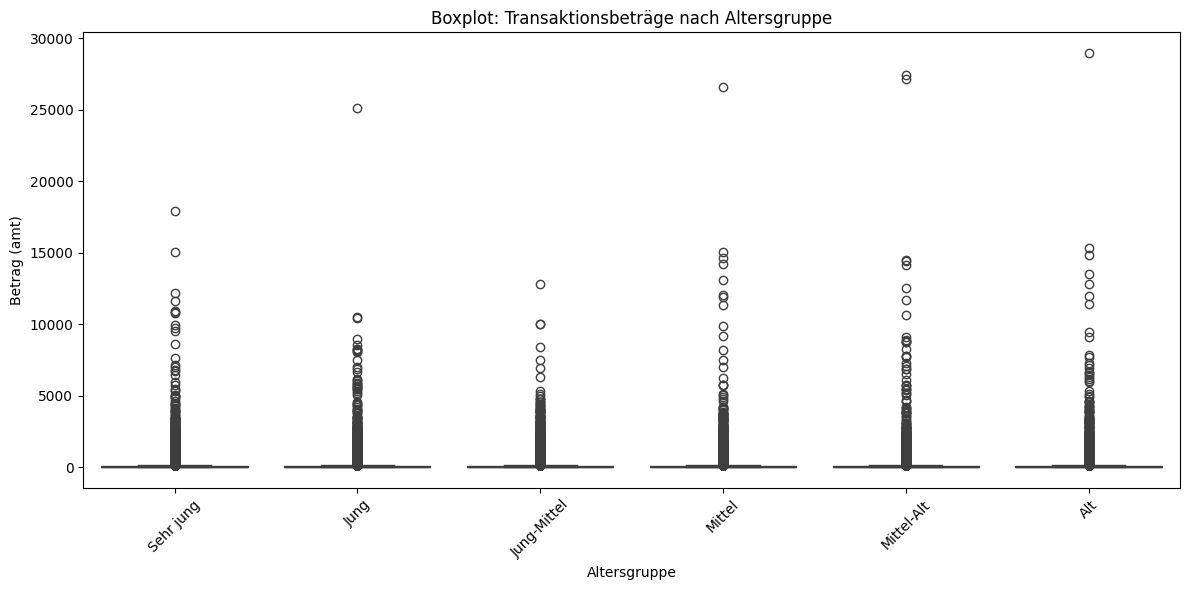

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=ds, x="age_group6", y="amt")
plt.xticks(rotation=45)
plt.title("Boxplot: Transaktionsbeträge nach Altersgruppe")
plt.xlabel("Altersgruppe")
plt.ylabel("Betrag (amt)")
plt.tight_layout()
plt.show()

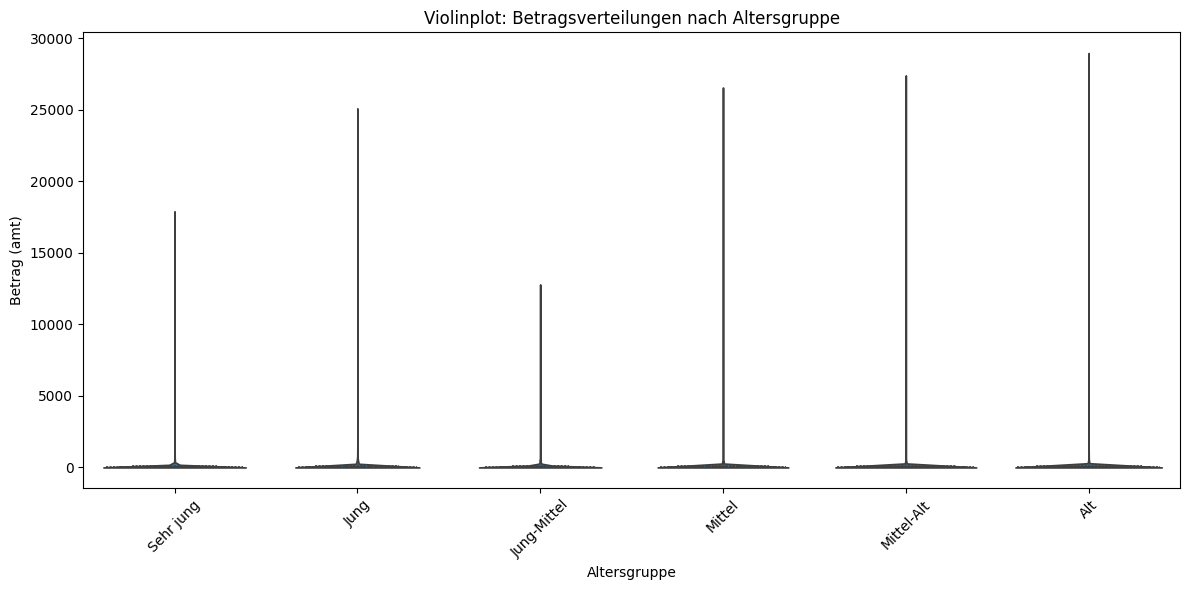

In [24]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=ds, x="age_group6", y="amt", cut=0, inner="quartile")
plt.xticks(rotation=45)
plt.title("Violinplot: Betragsverteilungen nach Altersgruppe")
plt.xlabel("Altersgruppe")
plt.ylabel("Betrag (amt)")
plt.tight_layout()
plt.show()

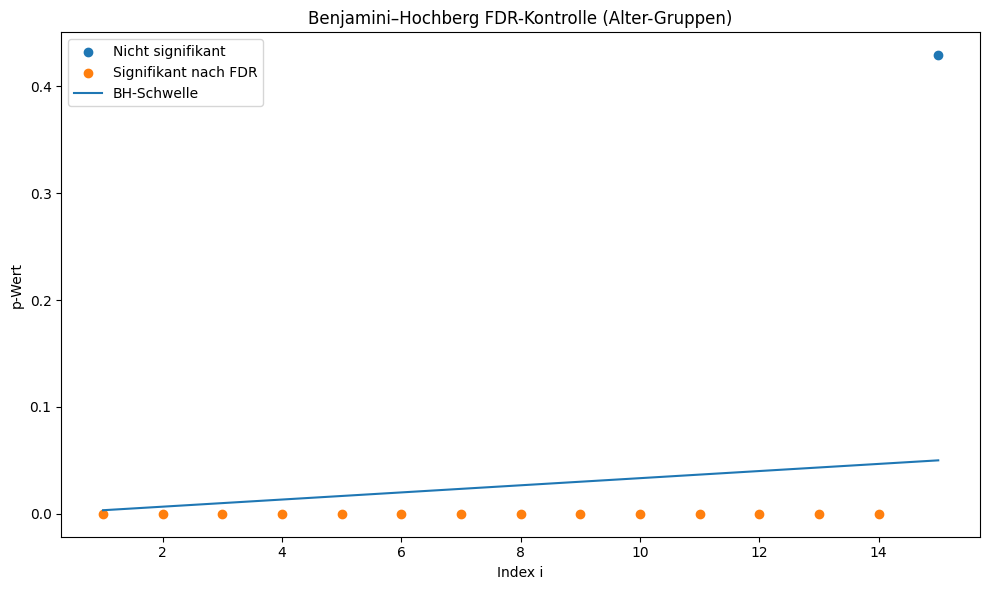

In [25]:
pvals = raw_dunn_age.values[np.triu_indices_from(raw_dunn_age, k=1)]
p_sorted = np.sort(pvals)
m = len(p_sorted)
alpha = 0.05
bh_thresholds = (np.arange(1, m+1)/m) * alpha

significant = p_sorted <= bh_thresholds

plt.figure(figsize=(10,6))
x = np.arange(1, m+1)

plt.scatter(x[~significant], p_sorted[~significant], label="Nicht signifikant")
plt.scatter(x[significant], p_sorted[significant], label="Signifikant nach FDR")
plt.plot(x, bh_thresholds, label="BH-Schwelle")

plt.xlabel("Index i")
plt.ylabel("p-Wert")
plt.title("Benjamini–Hochberg FDR-Kontrolle (Alter-Gruppen)")
plt.legend()
plt.tight_layout()
plt.show()

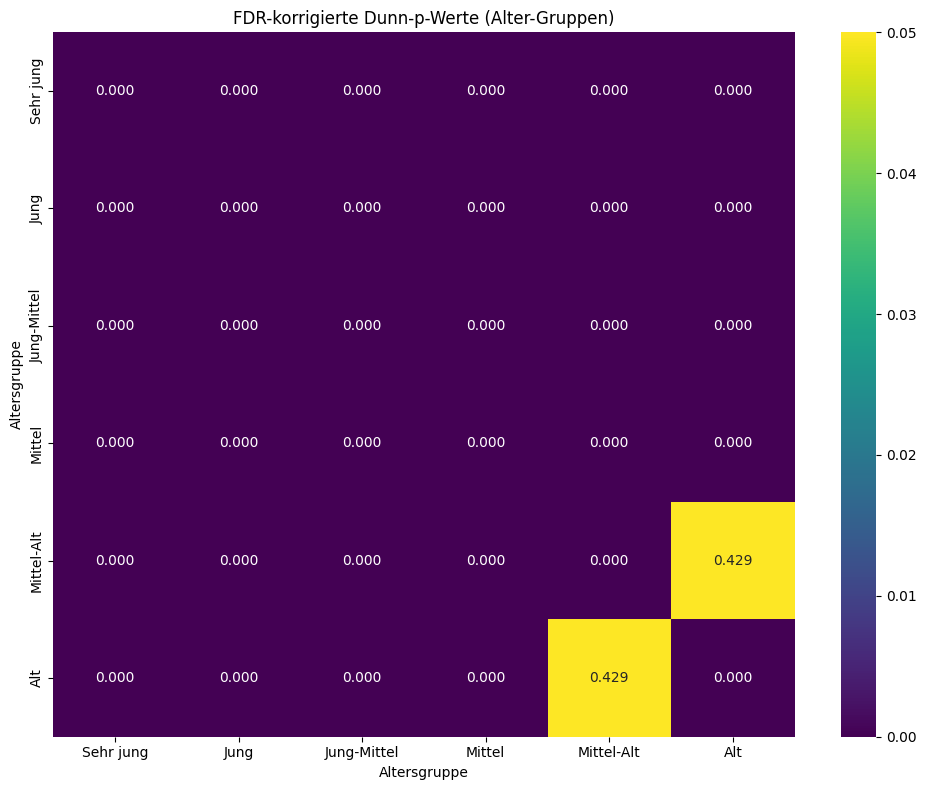

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_age, cmap="viridis", vmin=0, vmax=0.05, annot=True, fmt=".3f")
plt.title("FDR-korrigierte Dunn-p-Werte (Alter-Gruppen)")
plt.xlabel("Altersgruppe")
plt.ylabel("Altersgruppe")
plt.tight_layout()
plt.show()

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_17136/3648120886.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = ds.groupby("age_group6")["amt"].agg(["median", "mean"]).reset_index()


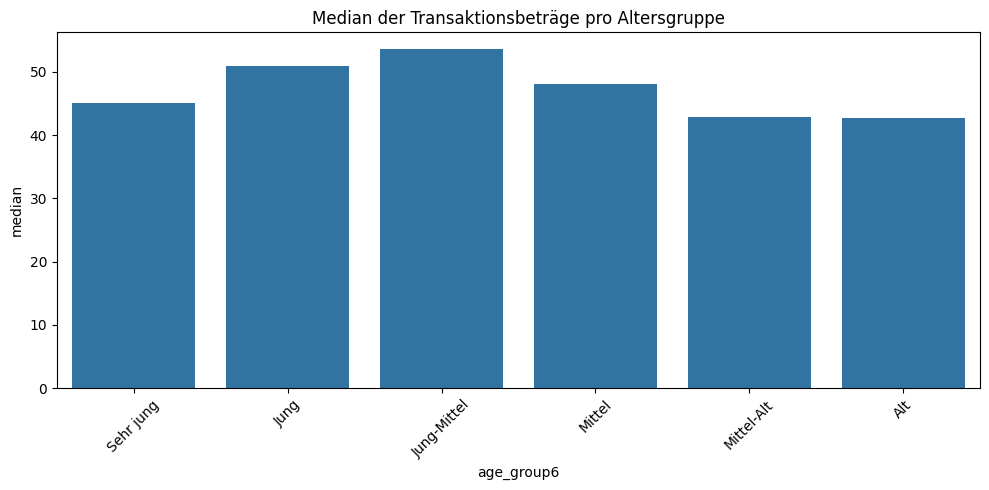

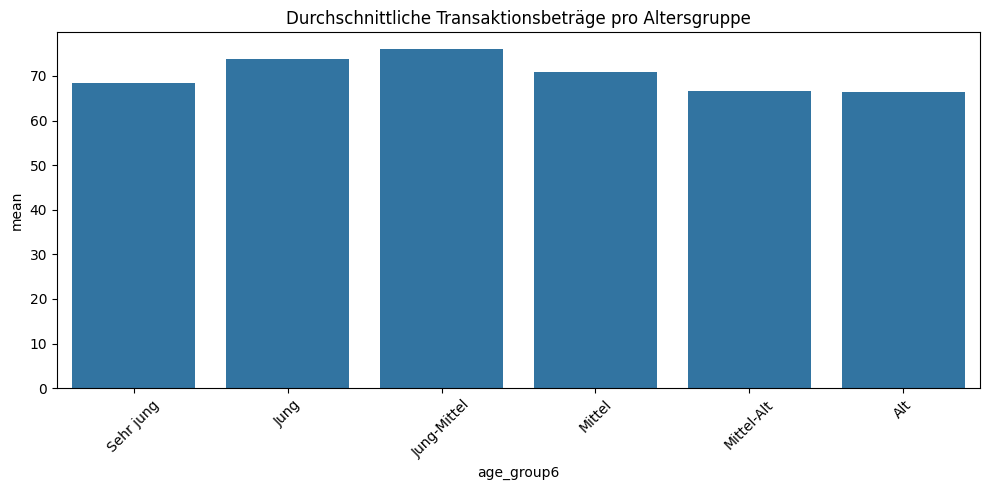

In [27]:
summary = ds.groupby("age_group6")["amt"].agg(["median", "mean"]).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=summary, x="age_group6", y="median")
plt.xticks(rotation=45)
plt.title("Median der Transaktionsbeträge pro Altersgruppe")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=summary, x="age_group6", y="mean")
plt.xticks(rotation=45)
plt.title("Durchschnittliche Transaktionsbeträge pro Altersgruppe")
plt.tight_layout()
plt.show()

In [31]:
# 1) Mittelwerte pro Altersgruppe
group_means = ds.groupby("age_group6")["amt"].mean()

# 2) Alle Paarvergleiche sammeln
rows = []

for i in range(len(corr_age.index)):
    for j in range(i+1, len(corr_age.columns)):
        g1 = corr_age.index[i]
        g2 = corr_age.columns[j]
        p  = corr_age.loc[g1, g2]

        m1 = group_means[g1]
        m2 = group_means[g2]

        diff = m2 - m1  # positive = Gruppe 2 zahlt mehr

        rows.append({
            "Gruppe 1": g1,
            "Gruppe 2": g2,
            "MW Gruppe 1": m1,
            "MW Gruppe 2": m2,
            "Differenz (G2 - G1)": diff,
            "p-Wert (FDR)": p
        })

# 3) DataFrame erzeugen
all_pairs_df = pd.DataFrame(rows)

# 4) p-Werte schön anzeigen (wissenschaftliche Notation)
all_pairs_df["p-Wert (FDR)"] = all_pairs_df["p-Wert (FDR)"].apply(lambda x: format(x, ".12e"))

# 5) Optional: sortieren nach p-Wert
all_pairs_df = all_pairs_df.sort_values("p-Wert (FDR)")

all_pairs_df

/var/folders/d7/0j6dg7256ms0w8n1z48lk8hc0000gn/T/ipykernel_17136/1900457929.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = ds.groupby("age_group6")["amt"].mean()


,Gruppe 1,Gruppe 2,MW Gruppe 1,MW Gruppe 2,Differenz (G2 - G1),p-Wert (FDR)
1,Sehr jung,Jung-Mittel,68.4148,75.9766,7.5618,0.000000000000e+00
8,Jung,Alt,73.7837,66.4633,-7.3204,0.000000000000e+00
10,Jung-Mittel,Mittel-Alt,75.9766,66.5292,-9.4474,0.000000000000e+00
11,Jung-Mittel,Alt,75.9766,66.4633,-9.5133,0.000000000000e+00
13,Mittel,Alt,70.9552,66.4633,-4.4919,1.215377681314e-113
6,Jung,Mittel,73.7837,70.9552,-2.8286,1.508266687755e-55
0,Sehr jung,Jung,68.4148,73.7837,5.3689,1.518068673927e-236
7,Jung,Mittel-Alt,73.7837,66.5292,-7.2545,1.640988350008e-307
3,Sehr jung,Mittel-Alt,68.4148,66.5292,-1.8856,2.214920396007e-06
5,Jung,Jung-Mittel,73.7837,75.9766,2.1929,2.215031291250e-60


In [32]:
def cohens_d(x, y):
    """Berechnet Cohen's d für zwei unabhängige Stichproben."""
    nx = len(x)
    ny = len(y)
    mx = np.mean(x)
    my = np.mean(y)
    vx = np.var(x, ddof=1)
    vy = np.var(y, ddof=1)

    # gepoolte Standardabweichung
    pooled_sd = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    d = (mx - my) / pooled_sd
    return d

# -----------------------------------------
# Cohen's d für alle Altersgruppenpaare
# -----------------------------------------
effects_d = []

groups = corr_age.index.tolist()

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        g1 = groups[i]
        g2 = groups[j]

        d1 = ds[ds["age_group6"] == g1]["amt"]
        d2 = ds[ds["age_group6"] == g2]["amt"]

        d = cohens_d(d1, d2)

        effects_d.append({
            "Gruppe 1": g1,
            "Gruppe 2": g2,
            "Cohen's d": d,
            "Effekt-Kategorie": (
                "negligible" if abs(d) < 0.2 else
                "small"       if abs(d) < 0.5 else
                "medium"      if abs(d) < 0.8 else
                "large"
            )
        })

effects_d_df = pd.DataFrame(effects_d)
effects_d_df.sort_values("Cohen's d", inplace=True, key=lambda col: abs(col))

effects_d_df

,Gruppe 1,Gruppe 2,Cohen's d,Effekt-Kategorie
14,Mittel-Alt,Alt,0.0004,negligible
3,Sehr jung,Mittel-Alt,0.0113,negligible
4,Sehr jung,Alt,0.0121,negligible
5,Jung,Jung-Mittel,-0.0147,negligible
2,Sehr jung,Mittel,-0.0157,negligible
6,Jung,Mittel,0.0176,negligible
12,Mittel,Mittel-Alt,0.0261,negligible
13,Mittel,Alt,0.0273,negligible
9,Jung-Mittel,Mittel,0.0329,negligible
0,Sehr jung,Jung,-0.0339,negligible
